In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/dog-emotions-prediction
/kaggle/input/dog-emotions-prediction/images
/kaggle/input/dog-emotions-prediction/images/angry
/kaggle/input/dog-emotions-prediction/images/sad
/kaggle/input/dog-emotions-prediction/images/relaxed
/kaggle/input/dog-emotions-prediction/images/happy
/kaggle/input/dog-emotion
/kaggle/input/dog-emotion/Dog Emotion
/kaggle/input/dog-emotion/Dog Emotion/angry
/kaggle/input/dog-emotion/Dog Emotion/sad
/kaggle/input/dog-emotion/Dog Emotion/relaxed
/kaggle/input/dog-emotion/Dog Emotion/happy


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
!rm /kaggle/input/dog-emotion/Dog Emotion/labels.csv

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


rm: cannot remove '/kaggle/input/dog-emotion/Dog': No such file or directory
rm: cannot remove 'Emotion/labels.csv': No such file or directory


In [4]:
import shutil
import os

# Define source and destination directories
source_dir = "/kaggle/input/dog-emotion/Dog Emotion"
destination_dir = "/kaggle/working/Dog Emotion1"

# Function to ignore specific files
def ignore_files(directory, files):
    return [file for file in files if file == 'labels.csv']

# Copy the entire directory structure, excluding 'label.csv'
shutil.copytree(source_dir, destination_dir, ignore=ignore_files)

print(f"Folders from '{source_dir}' have been copied to '{destination_dir}', excluding 'label.csv'")


Folders from '/kaggle/input/dog-emotion/Dog Emotion' have been copied to '/kaggle/working/Dog Emotion1', excluding 'label.csv'


In [5]:
batch_size = 32
img_height = 224
img_width = 224
data_dir = "/kaggle/working/Dog Emotion1"

In [6]:
num_skipped = 0
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 10 images.


In [7]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height,img_width),
  batch_size=batch_size)

Found 3990 files belonging to 4 classes.
Using 3192 files for training.
Using 798 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['angry', 'happy', 'relaxed', 'sad']


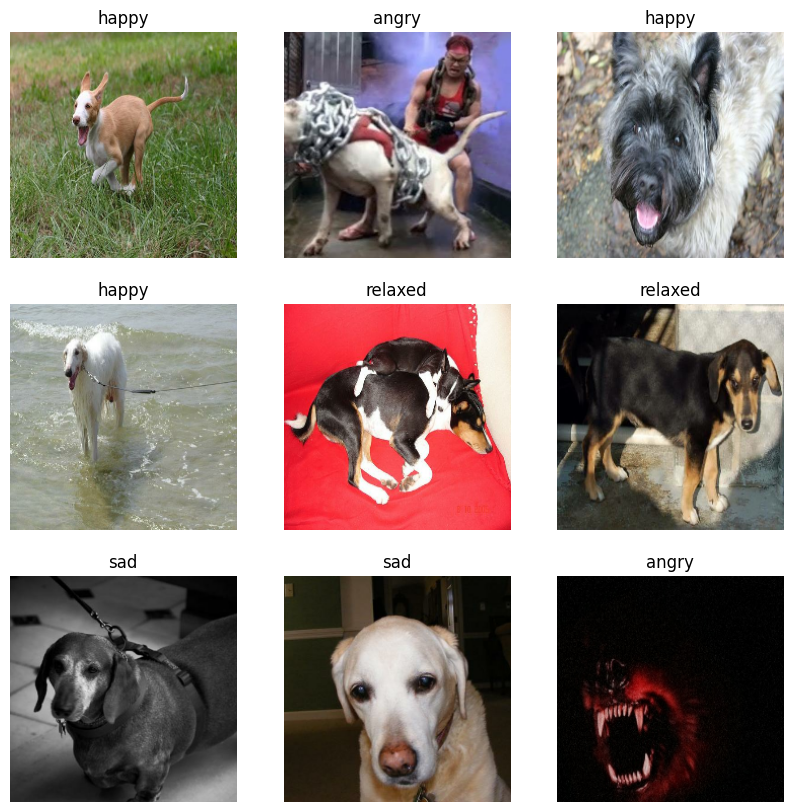

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.008782346 1.0


/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


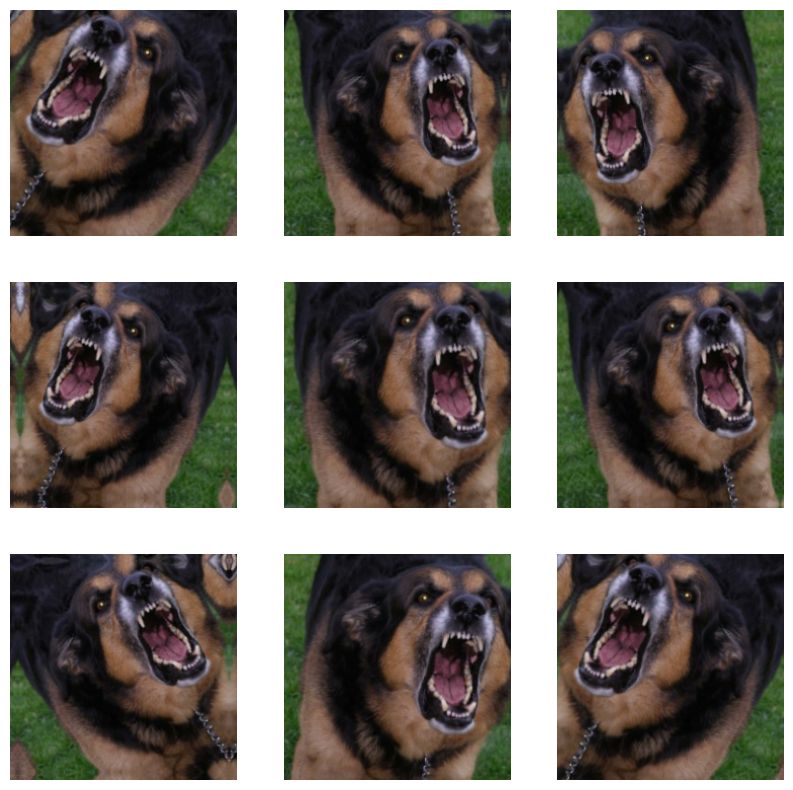

In [13]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [14]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

NameError: name 'num_classes' is not defined

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

# img = tf.keras.utils.load_img(
#     sunflower_path, target_size=(img_height, img_width)
# )
# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

In [ ]:
# Save the entire model as a `.keras` zip archive.
model.save('Mood_model.keras')

In [ ]:
new_model = tf.keras.models.load_model('Mood_model.keras')

# Show the model architecture
new_model.summary()

In [ ]:
# Evaluate the restored model
loss, acc = new_model.evaluate(val_ds)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

# print(new_model.predict(test_images).shape)